In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from PIL import Image
import os
import os.path
import glob
import argparse

In [2]:
#https://stackoverflow.com/questions/12299870/computing-x-y-coordinate-3d-from-image-point
#https://github.com/rodolfoap/OpenCV-2Dto3D/blob/master/transform.cpp
#https://www.elsevier.es/en-revista-journal-applied-research-technology-jart-81-articulo-projector-calibration-for-pattern-projection-S1665642314716086?fbclid=IwAR1wAECeNQMEBO-BF8HaAy1AvMraWlumSZ9NeSsTixzpgZJsH0H5O8mL14g

In [3]:
np.set_printoptions(suppress=True)

# Prepare object points for printed chessboard

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# (8,6) is for the given testing images.
# If you use the another data (e.g. pictures you take by your smartphone), 
# you need to set the corresponding numbers.
corner_x = 8
corner_y = 7
objp = np.zeros((corner_x*corner_y,3), np.float32)
objp[:,:2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1,2)
block_len = 2.5
objp = objp * block_len

# Prepare projector image points for projected chessboard

Start finding chessboard corners of depth image...
find the chessboard corners of chessboard/02.png


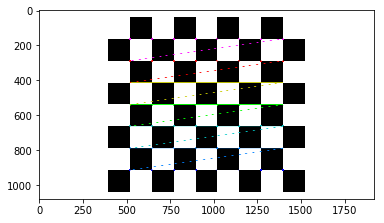

In [5]:
# Arrays to store object points and image points from all the images.
# objpoints = [] # 3d points in real world space
# projected_imgpoints = [] # 2d points in image plane.
chessboard_img_corners = []

pro_img_size = (10, 10)
img_size = (10, 10)

# Make a list of calibration images
images = glob.glob('chessboard/02.png')

# Step through the list and search for chessboard corners
print('Start finding chessboard corners of depth image...')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    pro_img_size = (img.shape[1], img.shape[0])

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, chessboard_img_corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
#         projected_imgpoints.append(chessboard_img_corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), chessboard_img_corners, ret)
        plt.imshow(img)
        


# Known camera intrinsic parameters

In [6]:
# #0210
# RGB_mtx = np.mat([[941.09129171,   0.,         638.94641198  ],
#  [  0.,         939.71879681, 364.60682026],
#  [  0.,           0.,           1.        ]])

# RGB_dist =  np.mat([[ 0.32649104, -1.06727582, -0.0025263,  -0.00531191,  1.09671098]])

In [7]:
#0212
RGB_mtx = np.mat([[920.41554065,   0.,         640.42506415 ],
 [  0.,         919.25718514, 359.86335889],
 [  0.,           0.,           1.        ]])

RGB_dist =  np.mat([[ 0.21651283, -0.6450563,  -0.00425079, -0.00337746,  0.56010408]])

# Calculate the extrinsic parameters for camera

find the chessboard corners of printed_chessboard\_00_0208.png
[[ 8.27616723]
 [ 8.94154515]
 [47.3646501 ]]

find the chessboard corners of printed_chessboard\_02_0208.png
[[ 2.0338038 ]
 [ 8.71107753]
 [48.43843043]]

find the chessboard corners of printed_chessboard\_04_0208.png
[[10.13713545]
 [ 9.13490932]
 [45.68257971]]

find the chessboard corners of printed_chessboard\_06_0208.png
[[ 8.93918946]
 [ 8.80593333]
 [44.91989745]]

find the chessboard corners of printed_chessboard\_08_0208.png
[[10.31867051]
 [ 8.92990376]
 [43.33031075]]



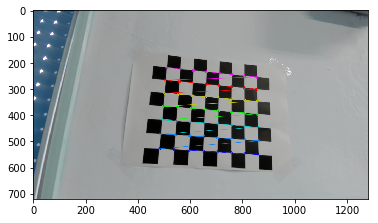

In [8]:
# Calculate the extrinsic parameters using the printed chessboard with the help of the calibrated camera.
T = []
R = []

images = glob.glob('printed_chessboard/*g')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    img_size = (img.shape[1], img.shape[0])

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, printed_corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)
    
    #criteria:角點精準化迭代過程的終止條件
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    #執行亞畫素級角點檢測
    printed_corners = cv2.cornerSubPix(gray,printed_corners,(11,11),(-1,-1),criteria)

    # If found, add object points, image points
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), printed_corners, ret)
        plt.imshow(img)
        
        retval, rvec, tvec = cv2.solvePnP(objp, printed_corners, RGB_mtx, RGB_dist)
        T.append(tvec)
        R.append(rvec)
        print(tvec)
        print()
#         print(rvec)
        #tvec rvec store into list

# Calculate the corners of the projected chessboard 
# (with camera's intrinsic and extrinsic matrix and its imagepoints)

In [9]:
from numpy.linalg import inv
def calculate_XYZ(u,v, rotationMatrix, translationVector, cameraMatrix):
    #https://github.com/rodolfoap/OpenCV-2Dto3D/blob/master/transform.cpp                                  
    #Solve: From Image Pixels, find World Points
    Z = 0;
    rotationMatrix,_ = cv2.Rodrigues(rotationMatrix)
    
    uv_1 = np.array([[u,v,1]], dtype=np.float32)
    uv_1 = uv_1.T
    
    invM_x_uv1 = np.matmul(inv(cameraMatrix),uv_1)
    invR_x_invM_x_uv1 = np.matmul(inv(rotationMatrix), invM_x_uv1)
    invR_x_tvec = np.matmul(inv(rotationMatrix), translationVector)
    
    s = (Z + invR_x_tvec[2]) / invR_x_invM_x_uv1[2]
#     print(s,invR_x_invM_x_uv1,invR_x_tvec)
    wcPoint =  s[0,0] * invR_x_invM_x_uv1 - invR_x_tvec

#     print(wcPoint)

    return np.float32(wcPoint.T[0])

In [10]:
# #Test the function (u,v ==> x,y,z=0)
# # print(projected_corners)
# p = calculate_XYZ(printed_corners[0,0,0],printed_corners[0,0,1], R[0], T[0], RGB_mtx)
# print(p)
# # print(objp)

find the chessboard corners of projected_chessboard\_01_0208.png
find the chessboard corners of projected_chessboard\_03_0208.png
find the chessboard corners of projected_chessboard\_05_0208.png
find the chessboard corners of projected_chessboard\_07_0208.png
find the chessboard corners of projected_chessboard\_09_0208.png


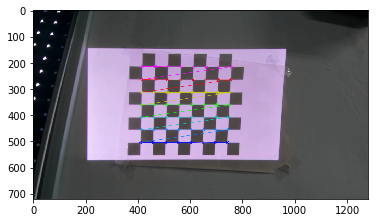

In [11]:
#Calculate the corners of the projected chessboard 
#with the help of the extrinsic and intrinsic parameters of the camera 
#and store in the ‘object points’ matrix.
projected_objpoints = []
projected_imgpoints = []
camera_imgpoints = [] 

# RGB_projected_imgpoints = [] # 2d points in image plane.

projected_obj = np.zeros((56,3), dtype=np.float32)

imgs = glob.glob('projected_chessboard/*g')
for idx, fname in enumerate(imgs):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    img_size = (img.shape[1], img.shape[0])

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    #projected_corners in RGB image space
    ret, projected_corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)
    
    #criteria:角點精準化迭代過程的終止條件
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    #執行亞畫素級角點檢測
    projected_corners = cv2.cornerSubPix(gray,projected_corners,(11,11),(-1,-1),criteria)

    # If found, add object points, image points
    if ret == True:
        projected_obj = np.zeros((56,3), dtype=np.float32)
        #projected points in RGB image space to would coord
        for i in range(56):
            #對應點找反==>反過來放 55-i 
            projected_obj[i,:] = calculate_XYZ(projected_corners[i,0,0], projected_corners[i,0,1], R[idx], T[idx], RGB_mtx)
            

#         print(projected_obj)
        projected_objpoints.append(projected_obj)
        
        projected_imgpoints.append(chessboard_img_corners)
        camera_imgpoints.append(projected_corners)
        
#         print(chessboard_img_corners)
#         print(projected_corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), projected_corners, ret)
        plt.imshow(img)

# print(projected_objpoints)

# Calibration projector

In [23]:
print(len(projected_objpoints), len(projected_imgpoints))
print(pro_img_size)

ret, projector_mtx, projector_dist, projector_rvecs, projector_tvecs = cv2.calibrateCamera(projected_objpoints, projected_imgpoints, pro_img_size,None,None)
projector_Vr = np.array(projector_rvecs)
projector_Tr = np.array(projector_tvecs)
projector_extrinsics = np.concatenate((projector_Vr, projector_Tr), axis=1).reshape(-1,6)

print(ret)
print(projector_mtx)
print(projector_dist)
print()
print(projector_extrinsics)
print(projector_Tr)

# print(projected_objpoints)

5 5
(1920, 720)
1.0844910917531587
[[2476.48031014    0.         1013.04903055]
 [   0.         2522.80193144  498.93242653]
 [   0.            0.            1.        ]]
[[ -0.64236698  10.06556384  -0.00967413   0.01746944 -59.72218646]]

[[ 0.39629702 -0.57550258 -2.99500413 10.17794945  9.70575286 47.01456852]
 [ 0.65424532 -0.56034805 -2.92136717  3.90429439  9.84630541 47.85504884]
 [ 0.2544124  -0.57794035 -2.99764843 12.04013671  9.83357447 45.34946104]
 [ 0.51833357 -0.56567591 -2.93974997 10.83622895  9.41343108 44.534284  ]
 [ 0.25003983 -0.60705736 -3.01818563 12.25231995  9.28681833 43.06523797]]
[[[10.17794945]
  [ 9.70575286]
  [47.01456852]]

 [[ 3.90429439]
  [ 9.84630541]
  [47.85504884]]

 [[12.04013671]
  [ 9.83357447]
  [45.34946104]]

 [[10.83622895]
  [ 9.41343108]
  [44.534284  ]]

 [[12.25231995]
  [ 9.28681833]
  [43.06523797]]]


In [13]:
# 0212
# 
# 1.1236793609340847
# [[2469.27788998    0.         1066.23583992]
#  [   0.         2509.42400807  480.78085559]
#  [   0.            0.            1.        ]]
# [[ -0.56228296   7.06848961  -0.02822939   0.01401298 -31.65963681]]



# 5 5
# (1920, 1080)
# 1.0844912312627883
# [[2476.51677569    0.         1013.05471363]
#  [   0.         2522.8325708   498.89785813]
#  [   0.            0.            1.        ]]
# [[ -0.64238416  10.06639038  -0.00967267   0.01746897 -59.73276966]]

In [14]:
# 5 5
# (1920, 1080)
# 1.5542472152788873
# [[2368.67855869    0.          929.85260966]
#  [   0.         2416.86764765  594.99909209]
#  [   0.            0.            1.        ]]
# [[  -0.68117196   15.15452139   -0.01482683    0.02300091 -138.5302292 ]]

# get the last one pair to compute the relationship between camera and projector

In [15]:
#get the last one pair
_projected_objpoints = []
_camera_imgpoints = []
_projected_imgpoints = []

_projected_objpoints.append(projected_objpoints[-1])
_camera_imgpoints.append(camera_imgpoints[-1])
_projected_imgpoints.append(projected_imgpoints[-1])

In [16]:
print('=== Result ===')
ret, projected_int, projected_cam_dist, RGB_cam_int, RGB_cam_dist, depth_rgb_rmat, depth_rgb_tvec, E, F = cv2.stereoCalibrate(
    _projected_objpoints, _projected_imgpoints, _camera_imgpoints, projector_mtx, projector_dist, RGB_mtx, RGB_dist, None)

print('  RMS :', ret)
print('  RGB Camera intrinsic parameters :')
print(RGB_cam_int, '    ')
print('  RGB Camera distortion parameters :')
print(RGB_cam_dist, '    ')
print()
print('  Projector intrinsic parameters :')
print(projected_int, '    ')
print('  Projector distortion parameters :')
print(projected_cam_dist, '    ')
print()
print('  Rotation matrix / translation vector from Projector to RGB camera')
print('  (they translate points from RGB camera coord to Projector coord) :')
print(depth_rgb_rmat, '    ')
print(depth_rgb_tvec, '    ')
print()
print('Rotation vector')
v,_ = cv2.Rodrigues(depth_rgb_rmat)
print(v)

=== Result ===
  RMS : 0.8408440566338119
  RGB Camera intrinsic parameters :
[[920.41554065   0.         640.42506415]
 [  0.         919.25718514 359.86335889]
 [  0.           0.           1.        ]]     
  RGB Camera distortion parameters :
[[ 0.21651283 -0.6450563  -0.00425079 -0.00337746  0.56010408]]     

  Projector intrinsic parameters :
[[2476.51677569    0.         1013.05471363]
 [   0.         2522.8325708   498.89785813]
 [   0.            0.            1.        ]]     
  Projector distortion parameters :
[[ -0.64238416  10.06639038  -0.00967267   0.01746897 -59.73276966]]     

  Rotation matrix / translation vector from Projector to RGB camera
  (they translate points from RGB camera coord to Projector coord) :
[[ 0.99916758 -0.01306901  0.03864396]
 [ 0.01695904  0.99462805 -0.10211478]
 [-0.03710183  0.10268514  0.99402174]]     
[[-3.46047105]
 [ 3.88101087]
 [ 0.32173184]]     

Rotation vector
[[0.10260839]
 [0.03794998]
 [0.01504459]]


In [17]:
# === Result === 0208
#   RMS : 1.8692166352398576
#   RGB Camera intrinsic parameters :
# [[913.24145912   0.         668.9538477 ]
#  [  0.         905.10342204 389.24919723]
#  [  0.           0.           1.        ]]     
#   RGB Camera distortion parameters :
# [[ 0.25755514 -0.92817129  0.00150453  0.01340316  1.17293952]]     

#   Projector intrinsic parameters :
# [[2521.16268336    0.         1083.50334751]
#  [   0.         2514.23761935  528.77304393]
#  [   0.            0.            1.        ]]     
#   Projector distortion parameters :
# [[ -0.68242654  10.11499507  -0.01528482   0.01467357 -64.00723976]]     

#   Rotation matrix / translation vector from RGB camera to Projector
#   (they translate points from Projector coord to RGB camera coord) :
# [[ 0.99971799  0.02347024  0.00361776]
#  [-0.02357488  0.99920105  0.03227212]
#  [-0.00285744 -0.03234831  0.99947257]]     
# [[ 3.30773975]
#  [-3.80873064]
#  [ 0.79646589]]     

# Rotation vector
# [[-0.03231888]
#  [ 0.00323847]
#  [-0.02352887]]

In [18]:
# Result 0207
# Projector intrinsic parameters :
# [[2632.88528666    0.          753.71811534]
#  [   0.         2633.13459721  611.01408057]
#  [   0.            0.            1.        ]]     
#   Projector distortion parameters :
# [[ -0.64789326   5.69455107   0.02388628  -0.00882401 -18.6186877 ]]  

# Rotation matrix / translation vector from RGB camera to Projector
#   (they translate points from RGB camera coord to Projector coord) :
# [[ 0.98172404  0.0298862   0.18794871]
#  [-0.0053981   0.99156793 -0.12947548]
#  [-0.19023345  0.12609463  0.97360741]]   

# [[-0.63573642]
#  [ 2.70586635]
#  [ 2.7919342 ]] 

# Rotation vector
# [[ 0.12892811]
#  [ 0.19078253]
#  [-0.01779997]]


In [19]:
import camera_calibration_show_extrinsics as show

Show the camera extrinsics


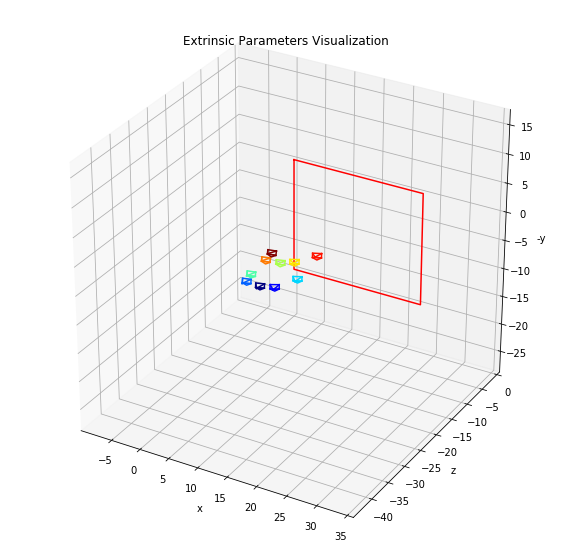

In [20]:
# show the camera extrinsics
print('Show the camera extrinsics')
camera_extrinsics = np.concatenate((R, T), axis=1).reshape(-1,6)
# plot setting
# You can modify it for better visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# camera setting
camera_matrix = RGB_mtx
cam_width = 0.064/0.1
cam_height = 0.032/0.1
scale_focal = 1600
# chess board setting
board_width = 9
board_height = 8
square_size = 2.5

Allextrinsics = np.zeros((camera_extrinsics.shape[0]+projector_extrinsics.shape[0],6))
Allextrinsics[:camera_extrinsics.shape[0]] = camera_extrinsics
Allextrinsics[camera_extrinsics.shape[0]:] = projector_extrinsics

# display
# True -> fix board, moving cameras
# False -> fix camera, moving boards
min_values, max_values = show.draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, Allextrinsics, board_width,
                                                board_height, square_size, True)

# _min_values, _max_values = show.draw_camera_boards(ax, RGB_cam_int, cam_width, cam_height,
#                                                 scale_focal, RGB_extrinsics, board_width,
#                                                 board_height, square_size, True)

X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, 0)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization')
plt.show()